In [2]:
from importlib import reload
import numpy as np
import pandas as pd

import util
import metrics
import estimators.linear as linear_estimators
import estimators.mtr as mtr_estimators
import plotting
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

SEEDS = [100,101]

## Figure 1
The synthetic data was generated from a SWP distribution with Gaussian noise, and then a dataframe with ones was fitted to the data.

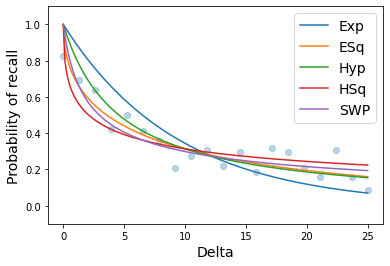

In [3]:
import matplotlib.pyplot as plt
reload(mtr_estimators)

np.random.seed(SEEDS[0])
def noisy_SWP(delta):
    delta = delta / (24*60*60)
    distribution_values = np.power((1+delta), -0.5)
    noise = np.random.normal(0, 0.1, len(delta), )
    return np.clip(distribution_values + noise, 0.0001, 0.999)

delta = np.linspace(0.00001, 25*24*60*60., 20)
df = pd.DataFrame({
    'delta': delta,
    'ones': np.ones(len(delta))
        }
    )
y = noisy_SWP(delta)

fitted_models = []

for estimator in mtr_estimators.all_estimators:
    model = estimator()
    model.fit(df, y)
    fitted_models.append(model)

delta_fit = np.linspace(0.00001, 25.*24*60*60, 200)
df_fit = pd.DataFrame({
    'delta': delta_fit,
    'ones': np.ones(len(delta_fit)
                   )
        }
    )
    
plt.scatter(delta/(24*60*60), y, alpha=0.3)
for model in fitted_models:
    if model.get_name() == 'HLR':
        continue
    name = model.get_name().strip('MTR-')
    plt.plot((delta_fit/(24*60*60)), model.predict(df_fit), label = name)
    
plt.title('')
plt.ylim([-0.1, 1.1])
plt.xlabel("Delta", fontsize=14)
plt.ylabel("Probability of recall", fontsize=14)
plt.rcParams.update({
            'legend.fontsize': 14
        })
plt.legend()

## Table 2

The file 'learning_traces.13m.csv' must be in the same folder as this notebook and the accompanying library code. 

Download from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N8XJME and decompress.

(In the paper, Linear Regression was omitted due to lack of space)

In [15]:
from sklearn.model_selection import KFold, train_test_split
reload(metrics)
reload(linear_estimators)
reload(mtr_estimators)

duolingo_df = pd.read_csv('learning_traces.13m.csv')
y = duolingo_df['p_recall']
X = duolingo_df.drop(['p_recall', 'timestamp','user_id', 'learning_language', 'ui_language', 'lexeme_id', 'lexeme_string'], axis=1)

def cross_validate_duolingo_dataset(folds, seeds, estimator_constructor, dataset='all'):
    if dataset not in datasets:
        raise Exception(f"dataset must be one of {datasets}")
    
    if dataset=='only-delta':
        X_subset = X[['delta']]
    if dataset=='only-history':
        X_subset = X[['history_seen', 'history_correct']]
    if dataset=='only-session':
        X_subset = X[['session_seen', 'session_correct']]
    if dataset=='without-delta':
        X_subset = X[['session_seen', 'session_correct','history_seen', 'history_correct']]
    if dataset=='all':
        X_subset = X
    
    y_trues                = []
    y_preds                = []

    for seed in seeds:
        kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        for train_index, test_index in kf.split(X):
                                    
            X_train = X_subset.iloc[train_index]
            X_test  = X_subset.iloc[test_index]
            y_train = y.iloc[train_index]
            y_test  = y.iloc[test_index]
            delta_train = X['delta'].iloc[train_index]
            delta_test  = X['delta'].iloc[test_index]

            estimator = estimator_constructor()
            estimator.fit(X_train, y_train, delta=delta_train)

            y_pred = estimator.predict(X_test, delta=delta_test)
            y_pred = np.clip(y_pred, 0.000001, 0.999999)

            y_trues.append(y_test)
            y_preds.append(y_pred)

    return metrics.DuolingoEvaluation.from_CV(estimator.get_name(),
                                                y_trues, 
                                                y_preds, 
                                                dataset=dataset
                                             )



datasets =  'only-history', 'only-session', 'only-delta', 'without-delta', 'all'
evals = []
for estimator in [
    linear_estimators.LogisticRegressionEstimator,
    linear_estimators.LinearRegressionEstimator,
    mtr_estimators.HLRForDuolingo
]:
    for dataset in datasets:
        evaluation = cross_validate_duolingo_dataset(5, SEEDS, estimator, dataset=dataset)
        print(evaluation.to_latex_tabular_row())
        evals.append(evaluation)

Logistic Regression & $H$ & 0.466 & 0.486 & 0.538 \\
Logistic Regression & $S$ & 0.0335 & 0.0111 & 1.00 \\
Logistic Regression & $\Delta$ & 0.467 & 0.488 & 0.517 \\
Logistic Regression & $H ^\frown S$ & 0.0335 & 0.0111 & 1.00 \\
Logistic Regression & $H ^\frown S ^\frown \Delta$ & 0.0335 & 0.0111 & 1.00 \\
Linear Regression & $H$ & 0.174 & 0.882 & 0.501 \\
Linear Regression & $S$ & 0.0658 & 0.357 & 0.985 \\


/home/charlie/.local/lib/python3.8/site-packages/sigfig/sigfig.py:571: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


Linear Regression & $\Delta$ & 0.174 & 0.884 & 0.500 \\
Linear Regression & $H ^\frown S$ & 0.0658 & 0.357 & 0.985 \\
Linear Regression & $H ^\frown S ^\frown \Delta$ & 0.0658 & 0.357 & 0.985 \\
HLR & $H$ & 0.150 & 0.901 & 0.506 \\
HLR & $S$ & 0.0943 & 0.378 & 0.789 \\


/home/charlie/.local/lib/python3.8/site-packages/sigfig/sigfig.py:571: UserWarning: warning: 3 significant figures requested from number with only 1 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


HLR & $\Delta$ & 0.124 & 0.953 & 0.500 \\
HLR & $H ^\frown S$ & 0.0937 & 0.377 & 0.790 \\
HLR & $H ^\frown S ^\frown \Delta$ & 0.0785 & 0.369 & 0.791 \\


#### Lomb tables and figures

We first need to load the dataset:

In [17]:
reload(util)
X, y, previous_recall_score = util.load_data()

## Figure 2


Text(0.5, 0, "'p_recall'")

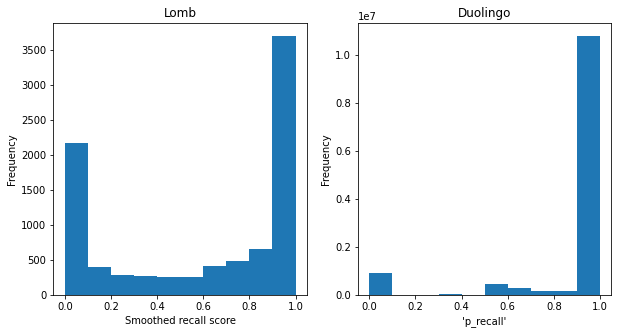

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

y.plot.hist(bins=10, ax=axes[0], title="Lomb")
axes[0].set_xlabel("Smoothed recall score")

duolingo_df['p_recall'].plot.hist(bins=10, title="Duolingo")
axes[1].set_xlabel("'p_recall'")


## Table 3
This presents the results of 5-fold, 2-pass CV on the Lomb dataset.

In [11]:
from sklearn.model_selection import KFold
import metrics
reload(metrics)
reload(mtr_estimators)
reload(linear_estimators)

def cross_validate_lomb_dataset(folds, seeds, estimator_constructor):
    y_trues                = []
    y_preds                = []
    previous_recall_scores = []
    deltas                 = []

    for seed in seeds:
        kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
        for train_index, test_index in kf.split(X):

            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]
            X_test  = X.iloc[test_index]
            y_test  = y.iloc[test_index]
            previous_recall_score_test = previous_recall_score.iloc[test_index]
            delta_test = X['delta'][test_index]

            estimator = estimator_constructor()
            estimator.fit(X_train, y_train)

            y_pred = estimator.predict(X_test)
            y_pred = np.clip(y_pred, 0.000001, 0.999999)

            y_trues.append(y_test)
            y_preds.append(y_pred)
            previous_recall_scores.append(previous_recall_score_test)
            deltas.append(delta_test)
    return metrics.LombEvaluation.from_CV(estimator.get_name(),
                                                y_trues, 
                                                y_preds, 
                                                previous_recall_scores, 
                                                deltas)

for estimator in linear_estimators.all_estimators+mtr_estimators.all_estimators:
    print(cross_validate_lomb_dataset(5, SEEDS, estimator).to_latex_tabular_row())

Linear Regression & 0.114 & 0.0182 $\pm$ 0.0030 & 0.000978 $\pm$ 0.00074 \\


/home/charlie/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/charlie/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

Logistic Regression & 0.116 & 0.0249 $\pm$ 0.0043 & 0.00138 $\pm$ 0.0011 \\
HLR & 0.171 & 0.0139 $\pm$ 0.0031 & 0.000560 $\pm$ 0.00034 \\
HLR & 0.171 & 0.0133 $\pm$ 0.0031 & 0.000421 $\pm$ 0.00020 \\
MTR-Exp & 0.246 & 0.0134 $\pm$ 0.0030 & 0.000397 $\pm$ 0.00020 \\
MTR-ESq & 0.198 & 0.0114 $\pm$ 0.0018 & 0.000351 $\pm$ 0.00015 \\
MTR-Hyp & 0.247 & 0.0140 $\pm$ 0.0028 & 0.000365 $\pm$ 0.00017 \\
MTR-HSq & 0.197 & 0.0114 $\pm$ 0.0018 & 0.000333 $\pm$ 0.00014 \\
MTR-SWP & 0.176 & 0.0109 $\pm$ 0.0021 & 0.000332 $\pm$ 0.00013 \\


## Figure 3

In [12]:
mtr_swp = mtr_estimators.SWPMuEstimator()
mtr_swp.fit(X, y)

mtr_hlr = mtr_estimators.HLRMuEstimator()
mtr_hlr.fit(X, y)

linear_regression = linear_estimators.LinearRegressionEstimator()
linear_regression.fit(X, y)

logistic_regression = linear_estimators.LogisticRegressionEstimator()
logistic_regression.fit(X, y)


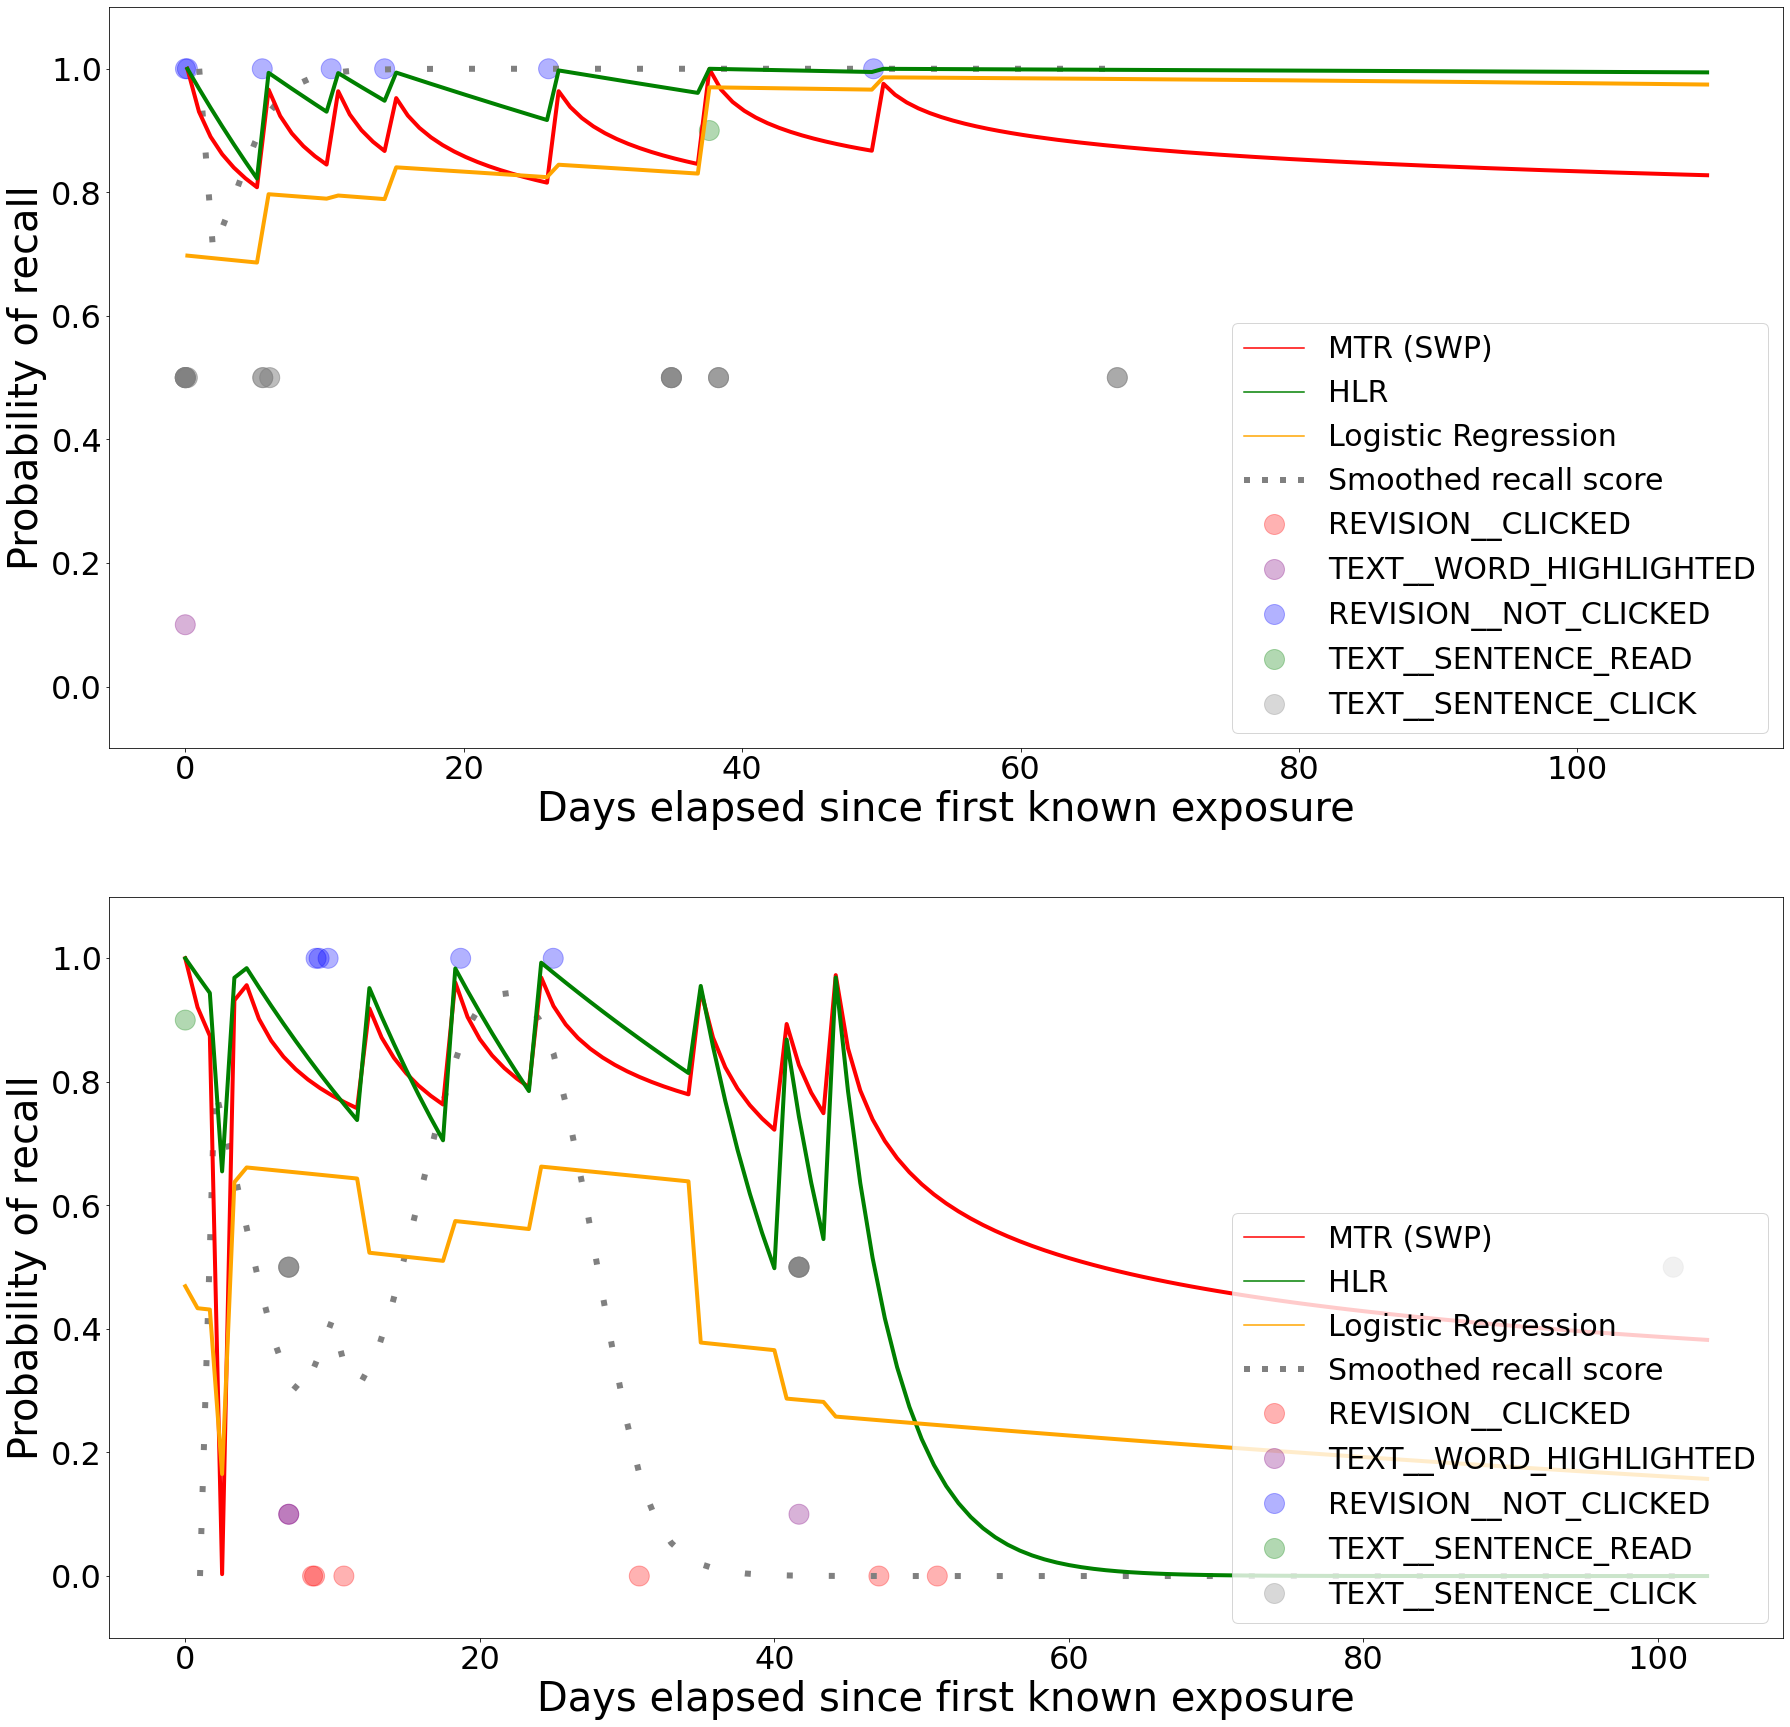

In [13]:
reload(plotting)
logs = util.load_logs()
plot_factory = plotting.PlotFactory(estimators = [
    plotting.EstimatorPlotDTO("MTR (SWP)",           "red",    mtr_swp), 
    plotting.EstimatorPlotDTO("HLR",                 "green",  mtr_hlr), 
    plotting.EstimatorPlotDTO("Logistic Regression", "orange", logistic_regression)
]
                                   )
plot_factory.config.add_time_after_last_timestamp = 30*24*60*60
plot_factory.config.interval_between_points       = 20*60*60
plot_factory.add_logs(logs)
top_lemmas_logs = plot_factory.top_lemmas(n=1000)
id_whitelist = ['user1_Nacken', 'user1_zupfen']
logs_to_plot = filter(lambda id : id[0] in id_whitelist, top_lemmas_logs)
ids_to_plot = list(map(lambda id : id[0], logs_to_plot))
plot_factory.plot_many(ids_to_plot)